# Imports 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.sparse.linalg
import scipy.spatial.distance

# Imported Classes

In [ ]:
# %%capture
!wget https://ese224.seas.upenn.edu/wp-content/uploads/2021/04/att_faces.zip -O att_faces.zip
!unzip -o att_faces.zip -d att_faces
!rm att_faces.zip

--2022-04-12 01:14:29--  https://ese224.seas.upenn.edu/wp-content/uploads/2021/04/att_faces.zip
Resolving ese224.seas.upenn.edu (ese224.seas.upenn.edu)... 158.130.67.172
Connecting to ese224.seas.upenn.edu (ese224.seas.upenn.edu)|158.130.67.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3769022 (3.6M) [application/zip]
Saving to: ‘att_faces.zip’

att_faces.zip       100%[===================>]   3.59M  6.51MB/s    in 0.6s    

2022-04-12 01:14:30 (6.51 MB/s) - ‘att_faces.zip’ saved [3769022/3769022]

Archive:  att_faces.zip
  inflating: att_faces/README        
   creating: att_faces/s1/
  inflating: att_faces/s1/6.pgm      
  inflating: att_faces/s1/7.pgm      
  inflating: att_faces/s1/8.pgm      
  inflating: att_faces/s1/9.pgm      
  inflating: att_faces/s1/10.pgm     
  inflating: att_faces/s1/1.pgm      
  inflating: att_faces/s1/2.pgm      
  inflating: att_faces/s1/3.pgm      
  inflating: att_faces/s1/4.pgm      
  inflating: att_faces/s1/5.pgm  

# Section 4.1

In [ ]:
class training_test_sets():
  def __init__(self, num_samples, im_set_path):
    self.num_samples = num_samples
    self.num_test_samples = 10 - num_samples
    self.im_set_path = im_set_path
    self.X_train = np.zeros((10304, 40*num_samples))
    self.y_train = np.zeros(40*num_samples)
    self.X_test = np.zeros((10304, 40*self.num_test_samples))
    self.y_test = np.zeros(40*self.num_test_samples)
      
  def solve(self):
    for ii in range(40):
      for jj in range(self.num_samples):
        im_path = self.im_set_path + '/s' + str(ii+1) + '/' + str(jj+1) + '.pgm'
        cur_img = mpimg.imread(im_path)
        self.X_train[:, ii*self.num_samples + jj] = np.ravel(cur_img)
        self.y_train[ii*self.num_samples + jj] = int(ii + 1)
      for jj in range(self.num_test_samples):
        im_path = self.im_set_path + '/s' + str(ii+1) + '/' + str(jj+10) + '.pgm'
        cur_img = mpimg.imread(im_path)
        self.X_test[:, ii*self.num_test_samples + jj] = np.ravel(cur_img)
        self.y_test[ii*self.num_test_samples + jj] = int(ii + 1)
    
    return self.X_train, self.y_train, self.X_test, self.y_test

# Section 5.1

In [ ]:
class training_set_PCA():
  def __init__(self, X_train, k):
    self.X_train = X_train
    self.k = k

  def solve(self):
    N, n_faces = self.X_train.shape
    mu = self.X_train.mean(axis=1)
    X = np.zeros((N, n_faces))
    for ii in range(n_faces):
      X[:, ii] = self.X_train[:, ii] - mu
    sigma = np.matmul(X, X.transpose()) 
    sigma /= n_faces
    _, sigma_eigs = scipy.sparse.linalg.eigs(sigma, k=self.k)
    P_H = np.conj(np.transpose(sigma_eigs))
    X_pca = np.matmul(P_H, X)
    return mu, sigma_eigs, X_pca

# Section 5.2

In [ ]:
class test_set_PCA():
  def __init__(self, mu, P, X_test):
    self.X_test = X_test
    self.mu = mu
    self.P = P
  
  def solve(self):
    N, n_faces = self.X_test.shape
    X = np.zeros((N, n_faces))
    for ii in range(n_faces):
      X[:, ii] = self.X_test[:, ii] - self.mu
    P_H = np.conj(np.transpose(self.P))
    X_pca = np.matmul(P_H, X)
    return X_pca

# Section 6.1

In [ ]:
class nearest_neighbors_classifier():  
  def __init__(self, X_train, X_test):
    self.X_train = X_train
    self.X_test = X_test

  def solve(self):
    distances = scipy.spatial.distance.cdist(self.X_train.transpose(), self.X_test.transpose())
    predicted_labels = np.argmin(distances, axis=0)
    return predicted_labels

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:187: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.ascontiguousarray(X, dtype=out_type)


<Figure size 432x288 with 0 Axes>

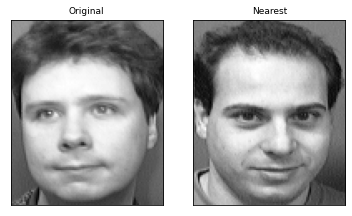

<Figure size 432x288 with 0 Axes>

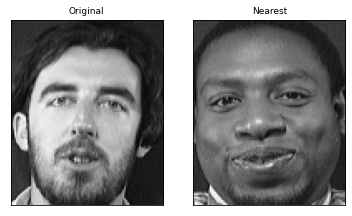

<Figure size 432x288 with 0 Axes>

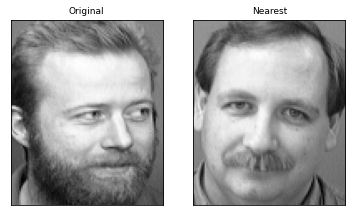

<Figure size 432x288 with 0 Axes>

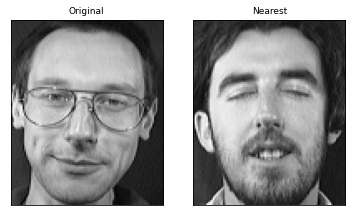

<Figure size 432x288 with 0 Axes>

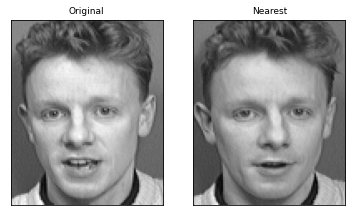

<Figure size 432x288 with 0 Axes>

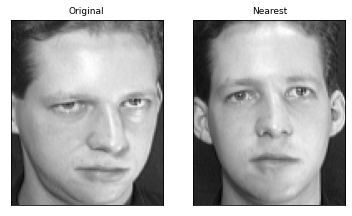

<Figure size 432x288 with 0 Axes>

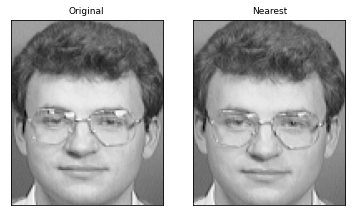

<Figure size 432x288 with 0 Axes>

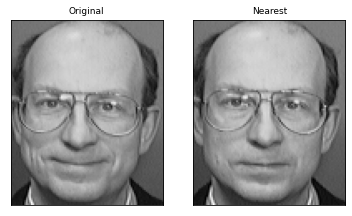

<Figure size 432x288 with 0 Axes>

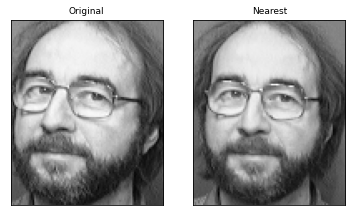

<Figure size 432x288 with 0 Axes>

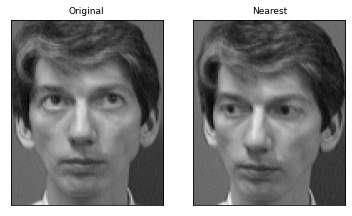

<Figure size 432x288 with 0 Axes>

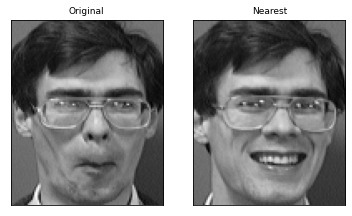

<Figure size 432x288 with 0 Axes>

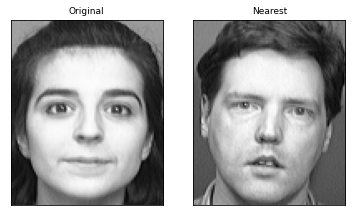

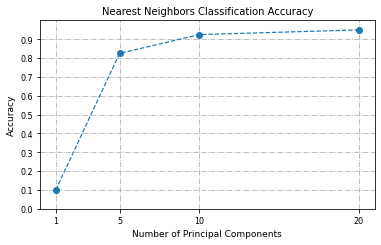

In [ ]:
# main method

if __name__ == '__main__':
  n_samples = 9
  im_dataset_path = 'att_faces'
  training_set_helper = training_test_sets(n_samples, im_dataset_path)

  training_set, training_labels, test_set, test_labels = training_set_helper.solve()
  
  list_of_ks = [1, 5, 10, 20]
  accuracy_list = np.zeros(len(list_of_ks))
  ii = 0
  n_examples = 3

  for k in list_of_ks:
    # PCA transform of all training points
    training_PCA = training_set_PCA(training_set, k)
    mean, PCA_mtx, training_PCAs = training_PCA.solve()

    # PCA transform of images in test set 
    test_PCA = test_set_PCA(mean, PCA_mtx, test_set)
    test_PCAs = test_PCA.solve() 

    # Find nearest neighbor
    nearest_label = nearest_neighbors_classifier(training_PCAs, test_PCAs)
    labels = nearest_label.solve()

    # Classification accuracy--test if each image is correct
    accuracy = np.mean(training_labels[labels] == test_labels)
    accuracy_list[ii] = accuracy 
    ii += 1

    for jj in range(n_examples):
      # choose random image from test set 
      im_number = np.random.randint(1, 40)
      im_path = im_dataset_path + '/s' + str(im_number) + '/' + str(10) + '.pgm'
      original_img = mpimg.imread(im_path)
      predicted = int(training_labels[labels[im_number-1]])
      s_number = labels[im_number - 1] - (predicted-1)*n_samples
      im_path = im_dataset_path + '/s' + str(predicted) + '/' + str(s_number+1) + '.pgm'
      nearest = mpimg.imread(im_path)
      plt.suptitle('Original and Nearest Images: k = ' + str(k), fontsize=10)
      fig = plt.figure()
      ax1 = fig.add_subplot(1,2,1)
      ax1.imshow(original_img, cmap='gray')
      ax1.axes.xaxis.set_visible(False)
      ax1.axes.yaxis.set_visible(False)
      plt.title('Original', fontsize=9)
      ax2 = fig.add_subplot(1,2,2)
      ax2.imshow(nearest, cmap='gray')
      ax2.axes.xaxis.set_visible(False)
      ax2.axes.yaxis.set_visible(False)
      plt.title('Nearest', fontsize=9)

      fig_path_name = 'k_' + str(k) + '_ex_' + str(jj) + '.png'
      plt.savefig(fig_path_name, dpi=300)
      plt.show()

  acc_plt = plt.figure()
  ax = acc_plt.add_subplot(111)
  ax.plot(np.asarray(list_of_ks), accuracy_list, 'tab:blue', marker='o', linestyle='dashed', linewidth=1.2, markersize=6)
  ax.grid(linestyle='-.')
  plt.title('Nearest Neighbors Classification Accuracy', fontsize=10)
  plt.xlabel('Number of Principal Components', fontsize=9)
  plt.ylabel('Accuracy', fontsize=9)
  plt.xticks(list_of_ks, fontsize=8)
  plt.yticks(np.arange(0, 1, step=0.1), fontsize=8)
  plt.xlim([0, list_of_ks[-1]+1])
  plt.ylim([0.0, 1.])
  ratio = 9/16
  xleft, xright = ax.get_xlim()
  ybottom, ytop = ax.get_ylim()
  ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
  fig_path_name = 'nearest_neighbors_accuracy.png'
  plt.savefig(fig_path_name, dpi=300)
  plt.show()



